In [1]:
import os
import glob

import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
from dynamic_routing_analysis import decoding_utils, plot_utils

%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
#set path to decoding results
loadpath=r"\\allen\programs\mindscope\workgroups\templeton\TTOC\decoding results\new_annotations\linear_shift_20_units"
files=glob.glob(os.path.join(loadpath,'*_decoding_results*.pkl'))

In [3]:
#load all trialwise decoding results, option to concatenate all sessions
concat_session_results=False
save_tables=False
return_table=False
loadpath=r"\\allen\programs\mindscope\workgroups\templeton\TTOC\decoding results\new_annotations\linear_shift_20_units\combined\no_normalization"
if save_tables:
    savepath=loadpath
else:
    savepath=None

if concat_session_results:
    combined_results=decoding_utils.concat_trialwise_decoder_results(files,savepath=savepath,return_table=return_table)
    if return_table:
        decoder_confidence_versus_response_type=combined_results[0]
        decoder_confidence_dprime_by_block=combined_results[1]
        decoder_confidence_by_switch=combined_results[2]
        decoder_confidence_versus_trials_since_rewarded_target=combined_results[3]
        decoder_confidence_before_after_target=combined_results[4]
else:
    decoder_confidence_versus_response_type=pd.read_csv(os.path.join(loadpath,'decoder_confidence_versus_response_type.csv'))
    decoder_confidence_dprime_by_block=pd.read_csv(os.path.join(loadpath,'decoder_confidence_dprime_by_block.csv'))
    decoder_confidence_by_switch=pd.read_csv(os.path.join(loadpath,'decoder_confidence_by_switch.csv'))
    decoder_confidence_versus_trials_since_rewarded_target=pd.read_csv(os.path.join(loadpath,'decoder_confidence_versus_trials_since_rewarded_target.csv'))
    decoder_confidence_before_after_target=pd.read_csv(os.path.join(loadpath,'decoder_confidence_before_after_target.csv'))


## plot correct reject minus false alarm decoder confidence across areas

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_15804\1287702840.py:26: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  cr_fa_diff_by_area['vis_context_cr_fa_diff_sem'].append(stats.sem(sel_area['vis_cr_confidence']-sel_area['vis_fa_confidence']))
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_15804\1287702840.py:29: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  cr_fa_diff_by_area['aud_context_cr_fa_diff_sem'].append(stats.sem(sel_area['aud_cr_confidence']-sel_area['aud_fa_confidence']))
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_15804\1287702840.py:33: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  cr_fa_diff_by_area['mean_diff_sem'].append(stats.sem(mean_diffs))
C:\Users\eth

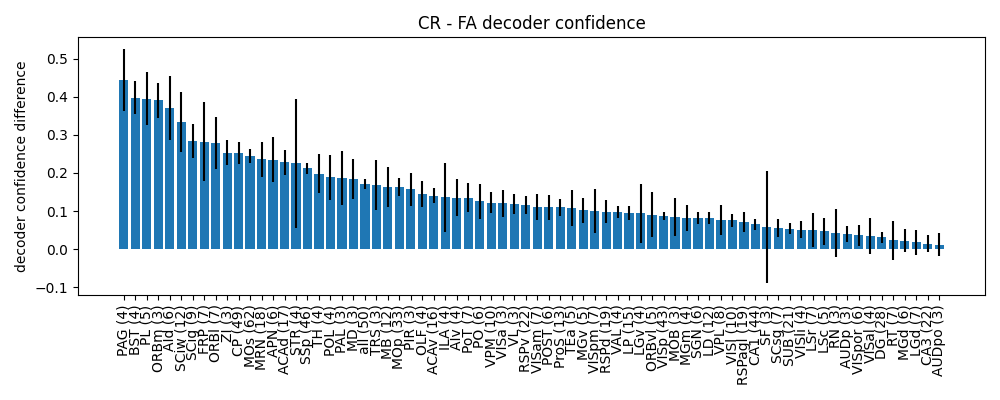

In [4]:
sel_project='DynamicRouting'
min_n_sessions=3
min_n_good_blocks=4

cr_fa_diff_by_area={
    'area':[],
    'n_sessions':[],
    'vis_context_dprime':[],
    'vis_context_cr_fa_diff':[],
    'vis_context_cr_fa_diff_sem':[],
    'aud_context_dprime':[],
    'aud_context_cr_fa_diff':[],
    'aud_context_cr_fa_diff_sem':[],
    'mean_diff':[],
    'mean_diff_sem':[],
    'total_diff':[],
}

for aa in decoder_confidence_versus_response_type['area'].unique():
    
    sel_area=decoder_confidence_versus_response_type.query('area==@aa and n_good_blocks>=@min_n_good_blocks and project.str.contains(@sel_project)')
    cr_fa_diff_by_area['area'].append(aa)
    cr_fa_diff_by_area['n_sessions'].append(len(sel_area))
    cr_fa_diff_by_area['vis_context_dprime'].append(np.mean(sel_area['vis_context_dprime']))
    cr_fa_diff_by_area['vis_context_cr_fa_diff'].append(np.mean(sel_area['vis_cr_confidence']-sel_area['vis_fa_confidence']))
    cr_fa_diff_by_area['vis_context_cr_fa_diff_sem'].append(stats.sem(sel_area['vis_cr_confidence']-sel_area['vis_fa_confidence']))
    cr_fa_diff_by_area['aud_context_dprime'].append(np.mean(sel_area['aud_context_dprime']))
    cr_fa_diff_by_area['aud_context_cr_fa_diff'].append(np.mean(sel_area['aud_cr_confidence']-sel_area['aud_fa_confidence']))
    cr_fa_diff_by_area['aud_context_cr_fa_diff_sem'].append(stats.sem(sel_area['aud_cr_confidence']-sel_area['aud_fa_confidence']))
    cr_fa_diff_by_area['mean_diff'].append(np.mean([cr_fa_diff_by_area['vis_context_cr_fa_diff'][-1],-cr_fa_diff_by_area['aud_context_cr_fa_diff'][-1]]))

    mean_diffs=(sel_area['vis_cr_confidence'].values+sel_area['aud_cr_confidence'].values)/2-(sel_area['vis_fa_confidence'].values+sel_area['aud_fa_confidence'].values)/2
    cr_fa_diff_by_area['mean_diff_sem'].append(stats.sem(mean_diffs))

    cr_fa_diff_by_area['total_diff'].append(np.sum([np.abs(cr_fa_diff_by_area['vis_context_cr_fa_diff'][-1]),np.abs(cr_fa_diff_by_area['aud_context_cr_fa_diff'][-1])]))


cr_fa_diff_by_area=pd.DataFrame(cr_fa_diff_by_area)

plot_data=cr_fa_diff_by_area.query('n_sessions>=@min_n_sessions').sort_values(by='mean_diff',ascending=False)

fig,ax=plt.subplots(figsize=(10,4))
ax.bar(plot_data['area'],plot_data['mean_diff'],yerr=plot_data['mean_diff_sem'])

area_labels=[]
for i in range(plot_data.shape[0]):
    area_labels.append(plot_data['area'].iloc[i]+' ('+str(plot_data['n_sessions'].iloc[i])+')')
ax.set_xticks(np.arange(len(plot_data)))
ax.set_xticklabels(area_labels,rotation=90,ha='center')
ax.set_ylabel('decoder confidence difference')

ax.set_title('CR - FA decoder confidence')

fig.tight_layout()


## correct - incorrect decoder confidence across areas

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_15804\573162211.py:20: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  correct_incorrect_diff_by_area['correct_incorrect_diff_sem'].append(stats.sem(sel_area['correct_confidence']-sel_area['incorrect_confidence']))
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_15804\573162211.py:20: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  correct_incorrect_diff_by_area['correct_incorrect_diff_sem'].append(stats.sem(sel_area['correct_confidence']-sel_area['incorrect_confidence']))
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_15804\573162211.py:20: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  correct_incorrect_diff_by_area['correct_incorrect

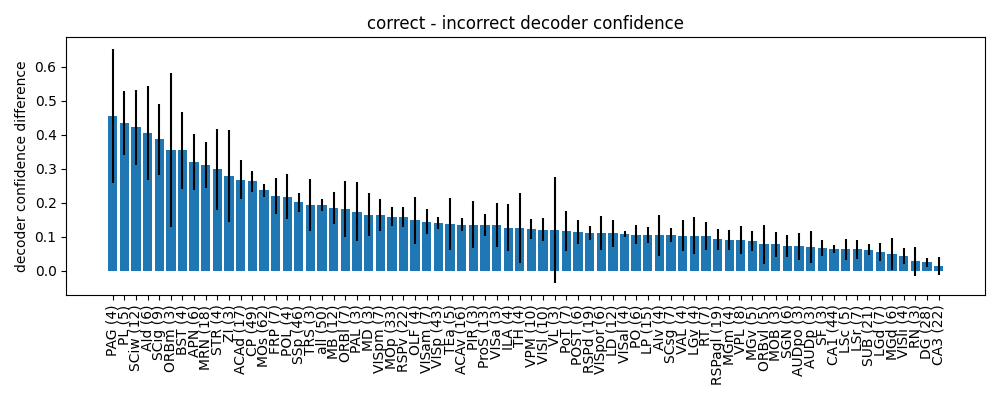

In [5]:
sel_project='DynamicRouting'
min_n_sessions=3
min_n_good_blocks=4

correct_incorrect_diff_by_area={
    'area':[],
    'n_sessions':[],
    'dprime':[],
    'correct_incorrect_diff':[],
    'correct_incorrect_diff_sem':[],

}

for aa in decoder_confidence_versus_response_type['area'].unique():
    sel_area=decoder_confidence_versus_response_type.query('area==@aa and n_good_blocks>=@min_n_good_blocks and project.str.contains(@sel_project)')
    correct_incorrect_diff_by_area['area'].append(aa)
    correct_incorrect_diff_by_area['n_sessions'].append(len(sel_area))
    correct_incorrect_diff_by_area['dprime'].append(np.mean(sel_area['overall_dprime']))
    correct_incorrect_diff_by_area['correct_incorrect_diff'].append(np.mean(sel_area['correct_confidence']-sel_area['incorrect_confidence']))
    correct_incorrect_diff_by_area['correct_incorrect_diff_sem'].append(stats.sem(sel_area['correct_confidence']-sel_area['incorrect_confidence']))

correct_incorrect_diff_by_area=pd.DataFrame(correct_incorrect_diff_by_area)

plot_data=correct_incorrect_diff_by_area.query('n_sessions>=@min_n_sessions').sort_values(by='correct_incorrect_diff',ascending=False)

fig,ax=plt.subplots(figsize=(10,4))
ax.bar(plot_data['area'],plot_data['correct_incorrect_diff'],yerr=plot_data['correct_incorrect_diff_sem'])

area_labels=[]
for i in range(plot_data.shape[0]):
    area_labels.append(plot_data['area'].iloc[i]+' ('+str(plot_data['n_sessions'].iloc[i])+')')
ax.set_xticks(np.arange(len(plot_data)))
ax.set_xticklabels(area_labels,rotation=90,ha='center')
ax.set_ylabel('decoder confidence difference')
ax.set_title('correct - incorrect decoder confidence')

fig.tight_layout()


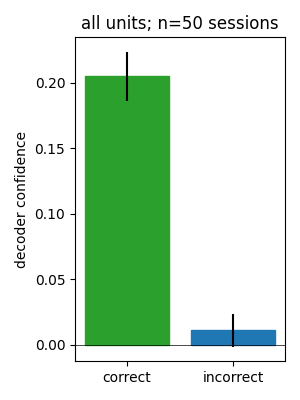

In [6]:
#correct vs. incorrect

#select area
aa='all'

sel_project='DynamicRouting'
min_n_recs=3
min_n_good_blocks=4

sel_area=decoder_confidence_versus_response_type.query('area==@aa and n_good_blocks>=@min_n_good_blocks and project.str.contains(@sel_project)')

fig,ax=plt.subplots(1,1,figsize=(3,4))
ax.axhline(0,color='k',linewidth=0.5)
bars=ax.bar([0,1],sel_area[['correct_confidence','incorrect_confidence',]].mean().values)
ax.errorbar([0,1],sel_area[['correct_confidence','incorrect_confidence']].mean().values,
            yerr=sel_area[['correct_confidence','incorrect_confidence',]].sem().values,linestyle='',color='k')
ax.set_xticks([0,1])
ax.set_xticklabels(['correct','incorrect'])
bars[0].set_color('tab:green')
bars[1].set_color('tab:blue')

ax.set_title(str(aa)+' units; n='+str(len(sel_area))+' sessions')
# ax.set_ylim([-0.05,0.4])
ax.set_ylabel('decoder confidence')
fig.tight_layout()

In [7]:
##TODO: plot/validate other trialwise analyses